## Goal

Write and evaluate a function to conduct fully stratified dataset sampling and/or train test splits.

A fully stratified sample will have the same, or as close as possible to the same distribution of all variable as in the full dataset.

## Plan

1. Start with an initial pesudorandom sample.
2. Compute Kolmogorov–Smirnov statistic for each variable, comparing sample and dataset.
3. Randomly replace observation with fresh draw from dataset
4. Recompute KS statistic.
5. Repeat

## Motivation

During evaluation of the initial gradient boosting model, I noticed that month does not rank highly in terms of feature importance. This observation did not make sense to me - there is clearly a peak wildfire season in California. The monthly trend in number of fires is present in the dataset but does not seem to be used by the model.

One possible explanation for this is the sampling method used. Drawing a few thousand observations randomly from several million might result is skewed distribution of months, making it hard for the model to learn their importance.

The logical conclusion to this line of reasoning was to think the same of all variables - the distribution in the sample should match the distribution in the full dataset if possible.

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ks_2samp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def k_random_sample(data, k):
    # Takes a data frame and an number of observations
    # returns dataframe containing k from n pseudorandom
    # observations with out replacement
    
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_sample(data, n):
    # takes a datafram and a sample size n, returns
    # n observations with positive and negative class
    # frequency matched to orignal data
    
    # split positive and negative datsets up
    ignitions = data[data['ignition'] == 1]
    no_ignitions = data[data['ignition'] == 0]
    
    # Calculate ignition & no ignition sample sizes
    ignition_fraction = len(ignitions) / len(data)
    ignition_sample_size = int((n * ignition_fraction))
    no_ignition_sample_size = int((n * (1 - ignition_fraction)))
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
    ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data

def make_train_test_sample(dataset, sample_size, train_test_split_ratio, rand_seed):
    # Takes data in dataframe, sample size, train test split
    # ratio and random seed. Samples n datapoints from dataset and then
    # runs stratified train test split on sample.
    # return stratified train test split data
    
    column_names = dataset.columns
    
    if 'weather_bin_time' in column_names:
        dataset = dataset.drop('weather_bin_time', axis=1)
    
    sampled_data = stratified_sample(dataset, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=train_test_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    return sampled_data, X_train, X_test, y_train, y_test

def two_sample_density_plot(
    plot_location, 
    parent_data, 
    sample_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
    y_scale
):
    parent_values, parent_base = np.histogram(parent_data[data_type], bins=40)
    sample_values, sample_base = np.histogram(sample_data[data_type], bins=40)
    
    parent_cumulative = np.cumsum(parent_values) / len(parent_data)
    sample_cumulative = np.cumsum(sample_values) / len(sample_data)

    ax[plot_location].plot(parent_base[:-1], (parent_values/len(parent_data)))
    ax[plot_location].plot(sample_base[:-1], (sample_values/len(sample_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_yscale(y_scale)
    
def ks_test(master_df, sample_ids, weather_variables):
    
    ks_pvals = []
    sample = master_df[master_df['ID'].isin(sample_ids)]
    
    for variable in weather_variables:
        master_data = np.array(master_df[variable])
        sample_data = np.array(sample[variable])

        ks_result = ks_2samp(master_data, sample_data)
        ks_pvals.append(ks_result[1])
    
    return ks_pvals

def replace_sample_subset(master_df, sample_ids, fraction):

    # rebuild sample
    sample = master_df[master_df.ID.isin(sample_ids)]
    #sample_positive = sample_positive[~sample_positive.ID.isin(ids_to_replace_positive)]
    
    # split sample into positive and negative
    sample_positive = sample[sample['ignition'] == 1]
    sample_negative = sample[sample['ignition'] == 0]

    # choose n random indexes to replace in each
    n_positive = len(sample_positive)
    k_positive = int(len(sample_positive)*fraction)
    indices_positive = random.sample(range(0, n_positive), k_positive)

    n_negative = len(sample_negative)
    k_negative = int(len(sample_negative)*fraction)
    indices_negative = random.sample(range(0, n_negative), k_negative)

    # grab data to replace and remove it from the sample
    data_to_replace_positive = sample_positive.iloc[indices_positive]
    ids_to_replace_positive = data_to_replace_positive.ID
    sample_positive = sample_positive[~sample_positive.ID.isin(ids_to_replace_positive)]

    data_to_replace_negative = sample_negative.iloc[indices_negative]
    ids_to_replace_negative = data_to_replace_negative.ID
    sample_negative = sample_negative[~sample_negative.ID.isin(ids_to_replace_negative)]

    # split parent data into positive and negative
    parent_positive = master_df[master_df['ignition'] == 1]
    parent_negative = master_df[master_df['ignition'] == 0]

    # grab replacement points
    eligible_parent_positive = sample_positive[~sample_positive.ID.isin(ids_to_replace_positive)]
    new_sample_positive = k_random_sample(eligible_parent_positive, k_positive)

    eligible_parent_negative = sample_negative[~sample_negative.ID.isin(ids_to_replace_negative)]
    new_sample_negative = k_random_sample(eligible_parent_negative, k_negative)

    # Add new points to sample and old points back to parent dataset
    sample_positive = sample_positive.append(new_sample_positive)
    sample_negative = sample_negative.append(new_sample_negative)
    sample = sample_positive.append(sample_negative)

    return sample

In [3]:
data_file = '../data/training_data/1992-1997_training_data_raw.csv'

sample_size = 50000
rand_seed = 42
train_test_split_ratio = 0.3

weather_variables = [
    'air.sfc',
    'air.2m', 
    'apcp',
    'crain',
    'rhum.2m',
    'dpt.2m',
    'pres.sfc',
    'uwnd.10m', 
    'vwnd.10m',
    'veg',
    'prate',
    'vis', 
]

In [4]:
# Load data
master_df = pd.read_csv(data_file, low_memory=False)

# Shuffel row order
master_df = master_df.sample(frac=1).reset_index(drop=True)

In [5]:
# Scale variables of intrest
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(master_df[weather_variables]), columns=weather_variables)

In [6]:
# Add back important columns that we did not scale
scaled_data['lat'] = master_df['lat']
scaled_data['lon'] = master_df['lon']
scaled_data['weather_bin_month'] = master_df['weather_bin_month']
scaled_data['weather_bin_year'] = master_df['weather_bin_year']
scaled_data['ignition'] = master_df['ignition']
scaled_data.describe()

,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,uwnd.10m,vwnd.10m,veg,prate,vis,lat,lon,weather_bin_month,weather_bin_year,ignition
count,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06,7.276544e+06
mean,-2.689322e-15,1.172731e-14,-2.707087e-16,-8.915785e-18,1.391120e-15,2.076485e-14,3.053869e-15,2.512888e-16,2.353765e-17,8.924691e-16,-9.266245e-17,3.392420e-15,3.712529e+01,-1.195260e+02,6.530760e+00,1.994497e+03,5.086151e-02
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.560793e+00,2.503722e+00,3.434363e+00,1.709219e+00,2.197149e-01
min,-3.339118e+00,-3.841424e+00,-2.045076e-01,-2.829242e-01,-1.942775e+00,-1.190267e+01,-3.477959e+00,-6.908907e+00,-5.866431e+00,-1.352922e+00,-6.560638e-01,-3.717590e+00,3.268389e+01,-1.243408e+02,1.000000e+00,1.992000e+03,0.000000e+00
25%,-7.175773e-01,-6.987625e-01,-2.045076e-01,-2.829242e-01,-8.589698e-01,-6.572676e-01,-6.293928e-01,-6.651686e-01,-6.784127e-01,-9.918262e-01,-2.058989e-01,3.594532e-01,3.499029e+01,-1.214709e+02,4.000000e+00,1.993000e+03,0.000000e+00
50%,-1.699751e-01,-8.946615e-02,-2.045076e-01,-2.829242e-01,-1.175395e-01,8.546164e-02,1.152746e-01,1.162303e-03,-1.245410e-02,-9.820348e-03,-1.819979e-01,3.597590e-01,3.683767e+01,-1.199051e+02,7.000000e+00,1.994000e+03,0.000000e+00
75%,5.940975e-01,6.599307e-01,-2.017126e-01,-2.829242e-01,8.586438e-01,7.392817e-01,7.970718e-01,6.311186e-01,6.382693e-01,5.890711e-01,-1.449899e-01,3.601838e-01,3.930418e+01,-1.174117e+02,9.000000e+00,1.996000e+03,0.000000e+00
max,3.527097e+00,3.589926e+00,5.303642e+01,3.534515e+00,1.890199e+00,3.153136e+00,1.707534e+00,7.256535e+00,9.424870e+00,2.332902e+00,5.715555e+01,3.630783e-01,4.197182e+01,-1.143645e+02,1.200000e+01,1.997000e+03,1.000000e+00


In [7]:
# Looks good, keep scaled data as master
master_df = scaled_data

# Add back unscaled variable we want to stratify
weather_variables = [
    'weather_bin_month',
    'weather_bin_year',
    'air.sfc',
    'air.2m', 
    'apcp',
    'crain',
    'rhum.2m',
    'dpt.2m',
    'pres.sfc',
    'uwnd.10m', 
    'vwnd.10m',
    'veg',
    'prate',
    'vis',
    'lat',
    'lon'
]

First, let's try the old way of doing it - take a pseudo random sample without replacement, stratifying by label and see if the distributions of weather variables are different in the sample vs the parent dataset.

In [8]:
# Take stratified sample of raw data and do stratified train_test split    
sample, X_train, X_test, y_train, y_test = make_train_test_sample(
    master_df, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

In [9]:
# For each weather variable, conduct 2 sample KS test to compare
# similarity of distributions

for variable in weather_variables:
    master_data = np.array(master_df[variable])
    sample_data = np.array(X_train[variable])
    
    ks_result = ks_2samp(master_data, sample_data)
    
    print("{} KS statistic: {} p-value: {}".format(variable, np.round(ks_result[0],3), np.round(ks_result[1],3)))

weather_bin_month KS statistic: 0.003 p-value: 0.946
weather_bin_year KS statistic: 0.005 p-value: 0.441
air.sfc KS statistic: 0.004 p-value: 0.683
air.2m KS statistic: 0.004 p-value: 0.569
apcp KS statistic: 0.003 p-value: 0.892
crain KS statistic: 0.001 p-value: 1.0
rhum.2m KS statistic: 0.003 p-value: 0.92
dpt.2m KS statistic: 0.004 p-value: 0.544
pres.sfc KS statistic: 0.007 p-value: 0.081
uwnd.10m KS statistic: 0.007 p-value: 0.096
vwnd.10m KS statistic: 0.004 p-value: 0.538
veg KS statistic: 0.002 p-value: 0.99
prate KS statistic: 0.003 p-value: 0.888
vis KS statistic: 0.004 p-value: 0.667
lat KS statistic: 0.004 p-value: 0.544
lon KS statistic: 0.003 p-value: 0.837


Does not look like we can outright reject the null for any of the tests.... but we do have some small-ish p-values. Let's take a look at the actual distributions by eye.

In [10]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 6
fig_cols = 3
plot_height = 35
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2),
    (5,0)
]

data_types = [
    'weather_bin_month',
    'weather_bin_year',
    'air.sfc',
    'air.2m',
    'prate',
    'apcp',
    'crain',
    'rhum.2m',
    'dpt.2m',
    'pres.sfc',
    'uwnd.10m', 
    'vwnd.10m',
    'vis',
    'veg',
    'lat',
    'lon'
]

plot_titles = [
    'Month',
    'Year',
    'Surface air temperature',
    'Air temperature at 2 meters',
    'Precipitation rate',
    'Acumulated precipitation',
    'Daily catagorical precipitation',
    'Relative humidity',
    'Dew point',
    'Surface pressure',
    'U-component of wind', 
    'V-component of wind',
    'Visibility',
    'Vegitation coverage',
    'Latitude',
    'Longitude'
]

weather_variable_labels = [
    'Month',
    'Year',
    'Temp.',
    'Temp.',
    'Rate',
    'Precipitation',
    'Precipitation',
    'Humidity',
    'Dew point',
    'Pressure',
    'Speed',
    'Speed',
    'Visibility',
    'Percent',
    'Degrees',
    'Degrees'
]

y_scales = [
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'log',
    'log',
    'linear',
    'linear',
    'linear',
    'linear',
    'linear',
    'log',
    'linear',
    'linear',
    'linear'
]

xlabels = weather_variable_labels
ylabels = ['Fraction observations'] * len(xlabels)

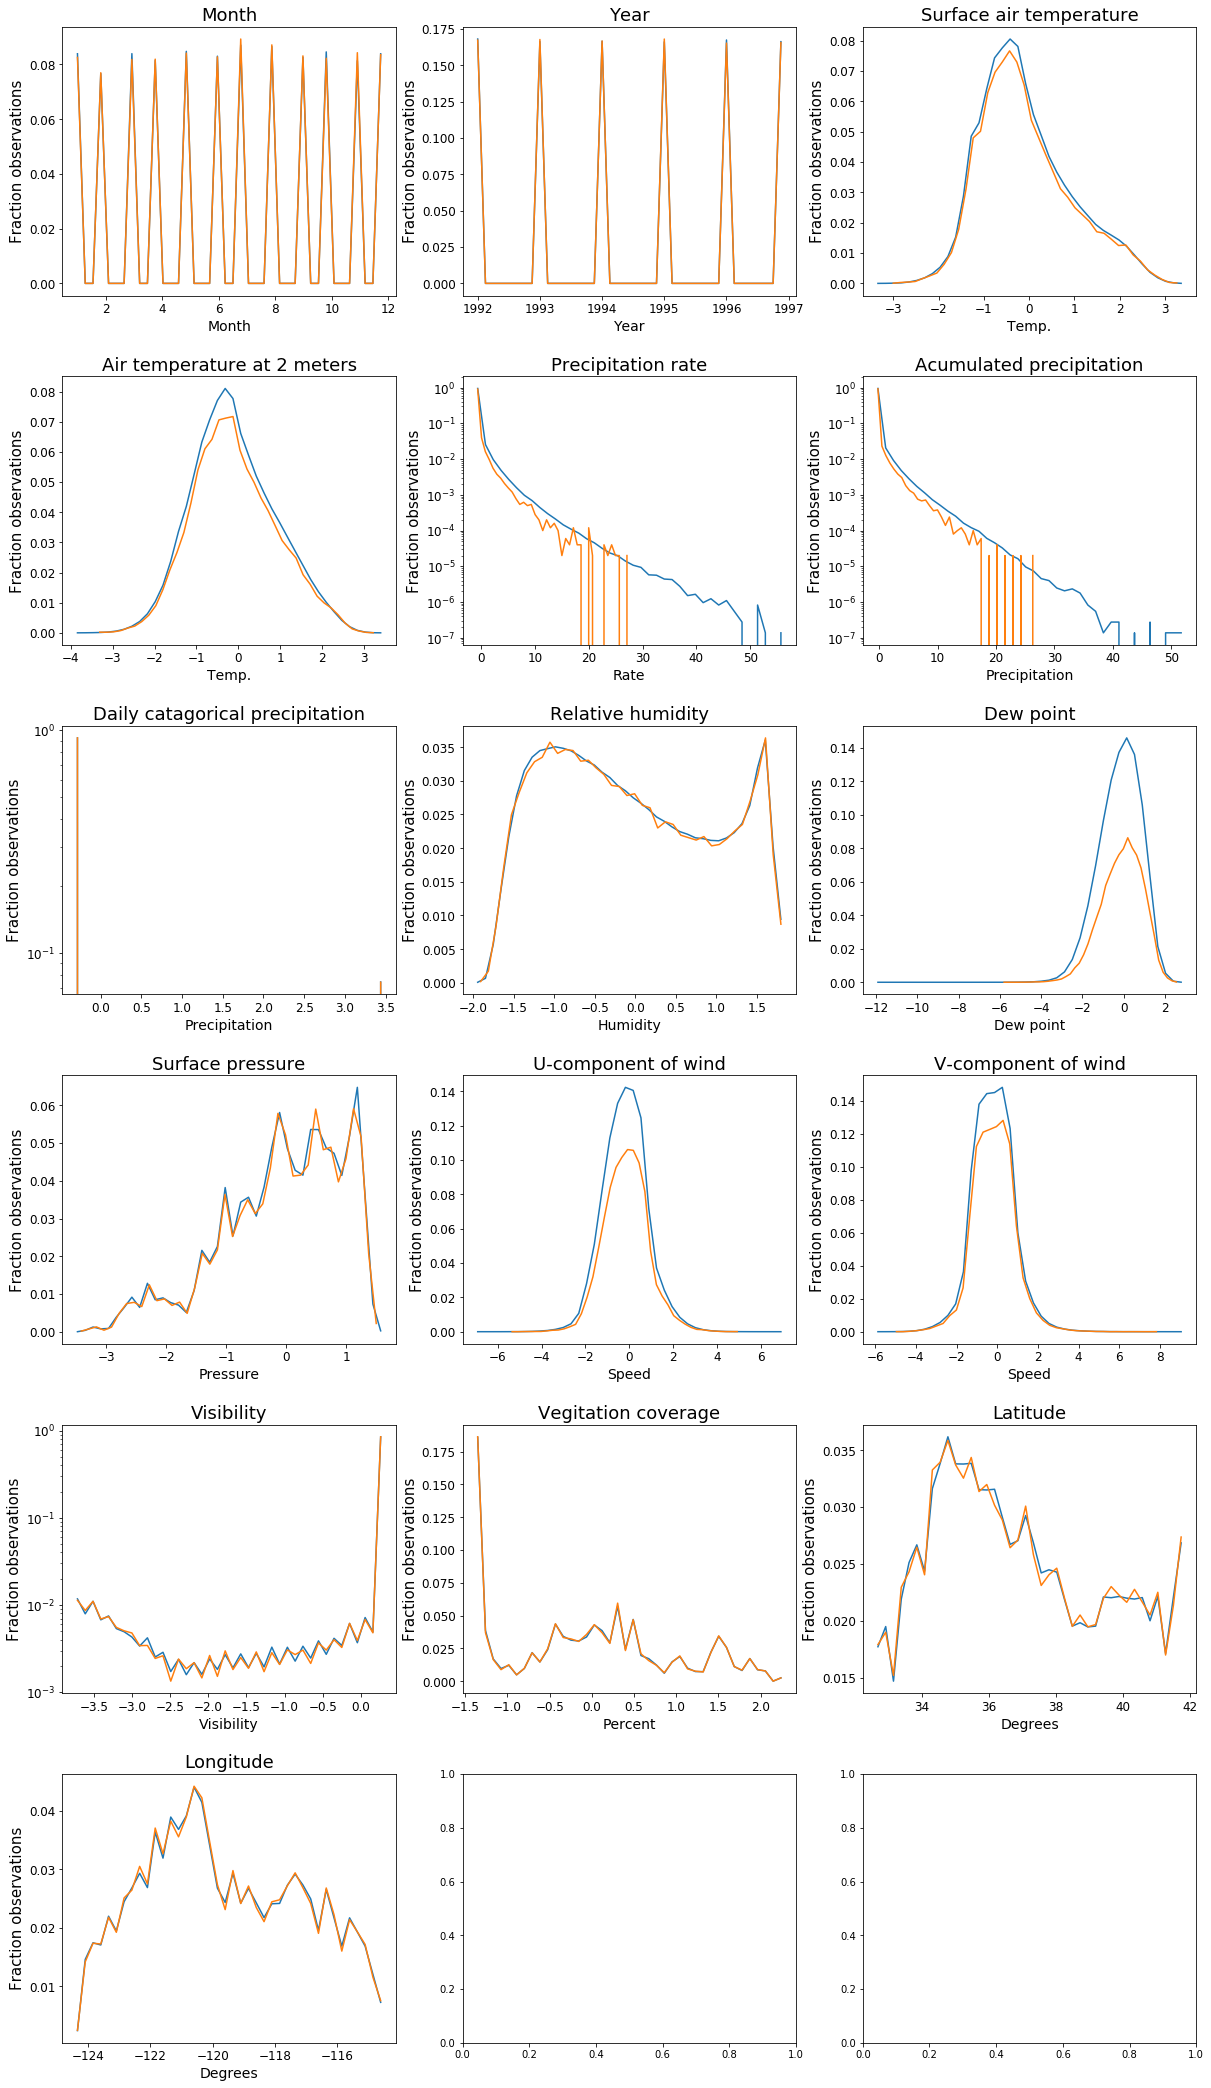

In [11]:
# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], master_df, sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

I think we should drill down further and look at the distributions of weather variables for positive and negative observations between the training set and parent set. Since the positive examples are such a small fraction of the total dataset and we are stratifying our sample, we are going to end up with an even smaller number of positive cases in the sample. This makes it more likely that the weather variable distributions will be different.

In [12]:
raw_positive = master_df[master_df['ignition'] == 1]
raw_negative = master_df[master_df['ignition'] == 0]
sample_positive = sample[sample['ignition'] == 1]
sample_negative = sample[sample['ignition'] == 0]

print("Percent ignitions parent dataset: {}".format(np.round((len(raw_positive)/len(master_df))*100),3))
print("Percent ignitions sample dataset: {}".format(np.round((len(sample_positive)/len(sample))*100),3))

print("\nTotal ignitions sample dataset: {}".format(len(sample_positive)))

Percent ignitions parent dataset: 5.0
Percent ignitions sample dataset: 5.0

Total ignitions sample dataset: 2543


OK, let's run our KS test again, this time comparing sample positives to parent positives.

In [13]:
for variable in weather_variables:
    master_data = np.array(raw_positive[variable])
    sample = np.array(sample_positive[variable])
    
    ks_result = ks_2samp(master_data, sample)
    
    print("{} KS statistic: {} p-value: {}".format(variable, np.round(ks_result[0],3), np.round(ks_result[1],3)))

weather_bin_month KS statistic: 0.019 p-value: 0.342
weather_bin_year KS statistic: 0.005 p-value: 1.0
air.sfc KS statistic: 0.023 p-value: 0.155
air.2m KS statistic: 0.015 p-value: 0.591
apcp KS statistic: 0.01 p-value: 0.947
crain KS statistic: 0.006 p-value: 1.0
rhum.2m KS statistic: 0.018 p-value: 0.382
dpt.2m KS statistic: 0.011 p-value: 0.911
pres.sfc KS statistic: 0.025 p-value: 0.091
uwnd.10m KS statistic: 0.02 p-value: 0.243
vwnd.10m KS statistic: 0.022 p-value: 0.165
veg KS statistic: 0.018 p-value: 0.386
prate KS statistic: 0.017 p-value: 0.481
vis KS statistic: 0.013 p-value: 0.776
lat KS statistic: 0.022 p-value: 0.169
lon KS statistic: 0.015 p-value: 0.582


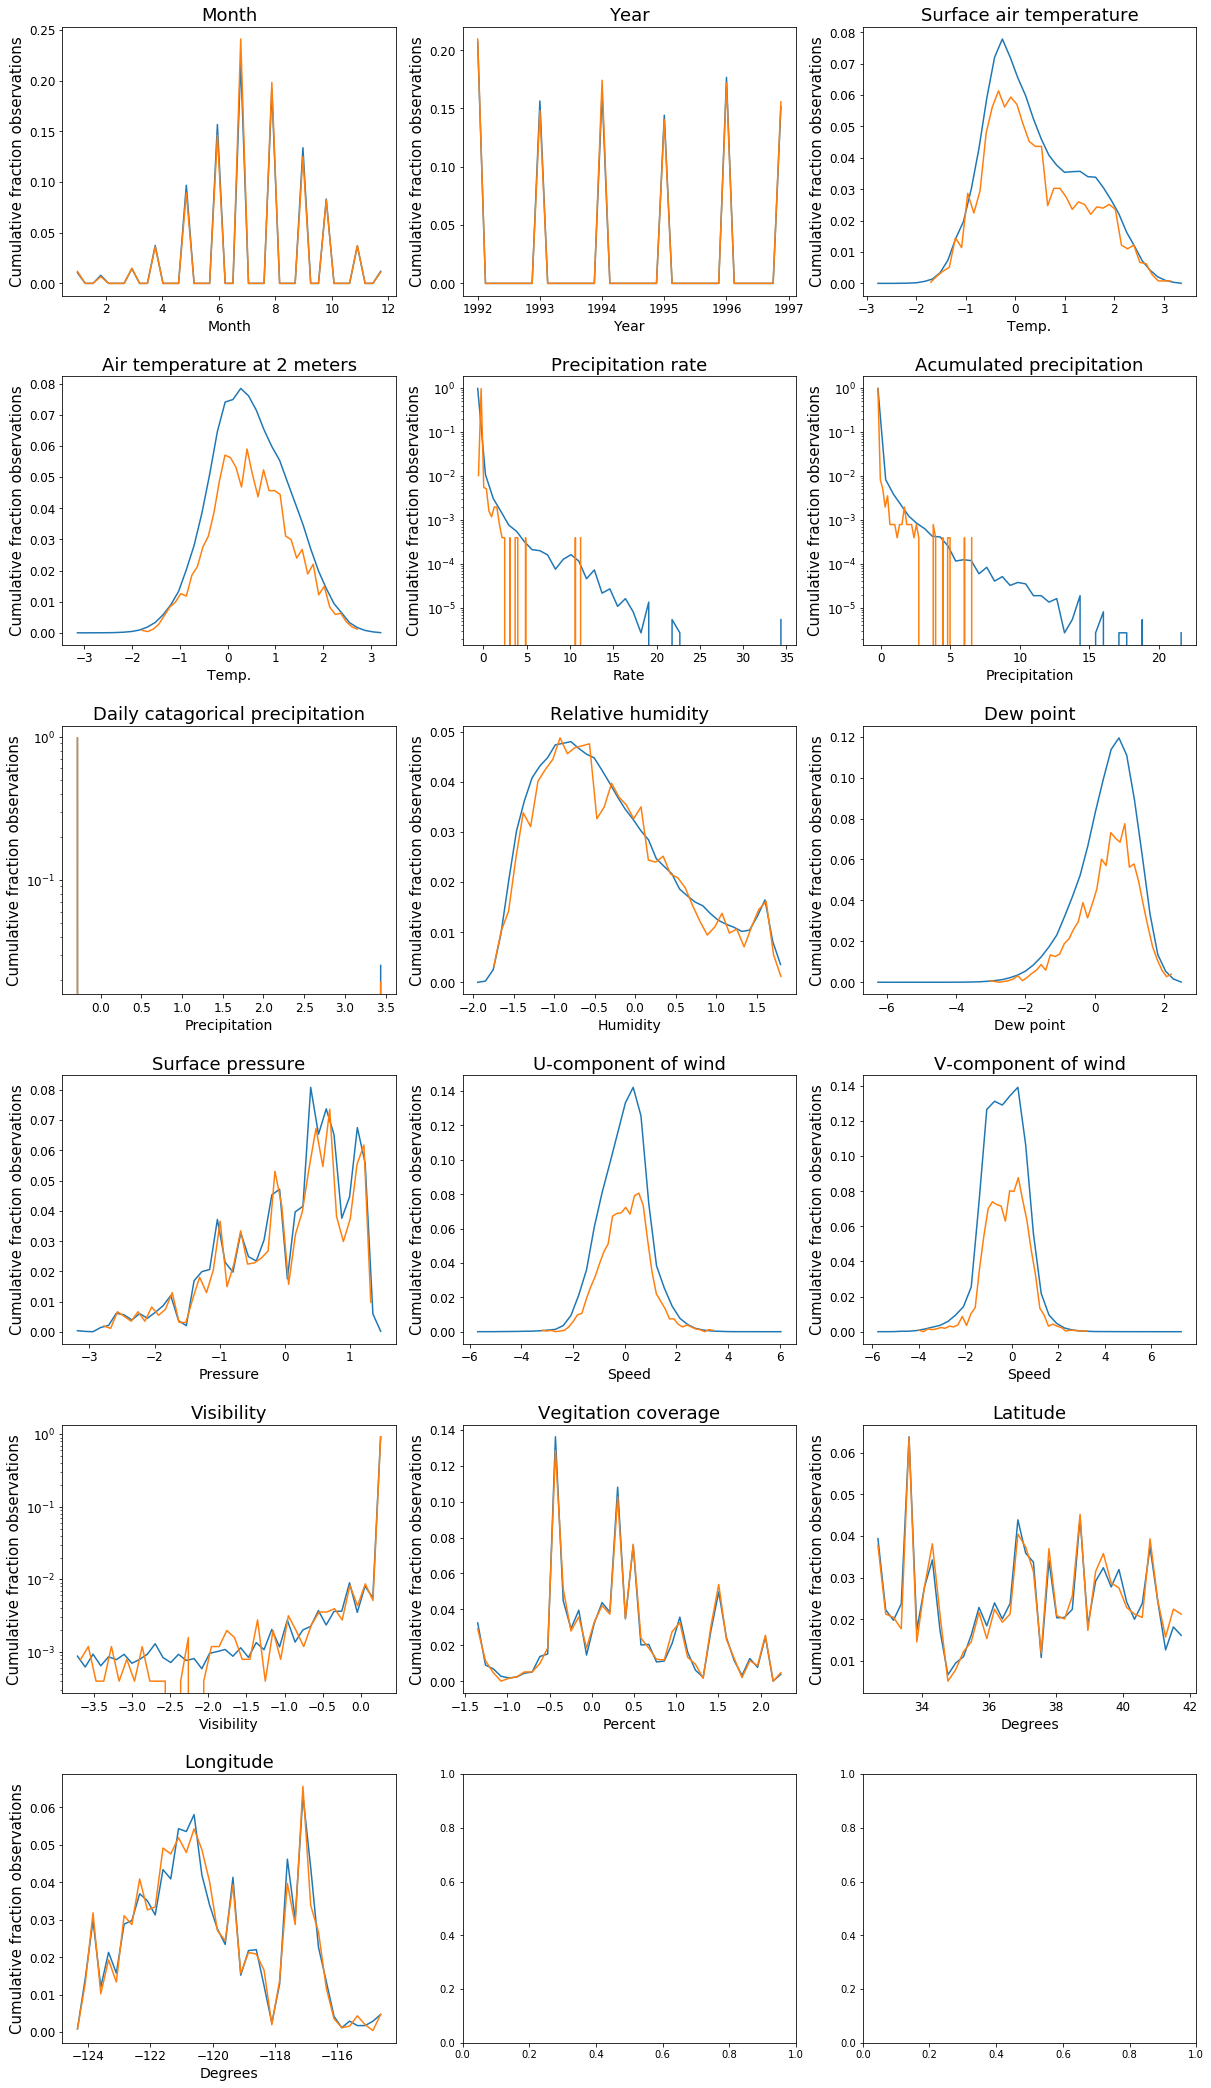

In [14]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], raw_positive, sample_positive, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

Maybe not surprisingly these look even more rough. As the sample size gets larger, we might expect this to be less and less of a problem. But let's try stratifying everything anyway... not sure how much it will help, but based on what I have seen, it looks like it is worth a shot. Start using a simple brute force random walk approach.

In [15]:
# Add unique id column
master_df.insert(0, 'ID', range(0, len(master_df)))

In [22]:
# Grab starting sample

# determine fraction positive observations in master data
fraction_positive = len(master_df[master_df['ignition'] == 1])/len(master_df)

# split positive and negative datsets up
ignitions = master_df[master_df['ignition'] == 1]
no_ignitions = master_df[master_df['ignition'] == 0]

# Calculate ignition & no ignition sample sizes
ignition_fraction = len(ignitions) / len(master_df)
ignition_sample_size = int((sample_size * ignition_fraction))
no_ignition_sample_size = int((sample_size * (1 - ignition_fraction)))

# sample data
no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

# combine
sample = no_ignitions_sample.append(ignitions_sample)

print("Sample ignitions: {}".format(len(sample[sample['ignition']==1])))
print("Sample size: {}".format(len(sample)))

Sample ignitions: 2543
Sample size: 49999


In [23]:
winning_sample = pd.DataFrame()
winning_ks_list = []
winning_step_nums = []
fraction = 0.1
old_distance = len(weather_variables)

target_pvals = [0.9] * len(weather_variables)

# itteritivly replace fraction of data and calculate KS statistic, keep winners
for i in range(50):

    sample_ids = sample['ID']
    ks_pvals = ks_test(master_df, sample_ids, weather_variables)
    distances = np.subtract(target_pvals, ks_pvals)
    total_distance = sum(np.square(distances)) ** 0.5
    
    if total_distance <= old_distance:
        # if we win, replace winning sample
        print("New winner, round {} - total p-value distance: {}".format(i, np.round(total_distance, 4)))
        winning_sample = sample
        old_distance = total_distance
        
        # Then resample and move on
        sample = replace_sample_subset(master_df, sample_ids, fraction)
        
    else:
        # If we did not win, go back to our last winner, resample and move on
        sample = winning_sample
        print("Round {} - total p-value distance: {}".format(i, np.round(total_distance, 4)))
        sample = replace_sample_subset(master_df, sample_ids, fraction)

New winner, round 0 - total p-value distance: 1.6683
Round 1 - total p-value distance: 1.7782
New winner, round 2 - total p-value distance: 1.5841
Round 3 - total p-value distance: 1.7971
Round 4 - total p-value distance: 2.0423
Round 5 - total p-value distance: 2.0924
Round 6 - total p-value distance: 2.1333
Round 7 - total p-value distance: 2.316
Round 8 - total p-value distance: 2.2193
Round 9 - total p-value distance: 2.2618
Round 10 - total p-value distance: 2.3216
Round 11 - total p-value distance: 2.2297
Round 12 - total p-value distance: 2.2059
Round 13 - total p-value distance: 2.1715
Round 14 - total p-value distance: 2.0655
Round 15 - total p-value distance: 1.8881
Round 16 - total p-value distance: 2.0157


KeyboardInterrupt: 

In [ ]:
# Make density plots
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = two_sample_density_plot(plot_locations[i], master_df, winning_sample, data_types[i], plot_titles[i], xlabels[i], ylabels[i], y_scales[i])
    
plt.show()

In [ ]:
for variable in weather_variables:
    parent_data = np.array(master_df[variable])
    sample = np.array(winning_sample[variable])
    
    ks_result = ks_2samp(parent_data, sample)
    
    print("{} KS statistic: {} p-value: {}".format(variable, np.round(ks_result[0],3), np.round(ks_result[1],3)))